In [4]:
import os
import time

from collections import Counter

import random
import numpy as np
import pandas as pd
import seaborn as sn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchtext.legacy import data
from torchtext.vocab import Vectors, FastText

from tqdm import notebook

from argparse import Namespace

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

[Workaround](https://github.com/NVIDIA/flowtron/issues/93)

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [6]:
args = Namespace(
    dataset_dir = ".data",
    dataset_prefix = "faq_with_splits_",
    datasets = ["lemmatized", "lemmatized_filtered"],
    model_save_dir = ".model_storage/LSTM",
    model_state_file = "model",
    seed = 1234,
    num_epochs = 20,
    learning_rate = 1e-3,
    batch_size = 70,
    cuda = True,
    train_column = ['long_question', 'short_question'],
    embedding_dim = 300,
    hidden_dim = 100
)

In [7]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = True

In [8]:
device = torch.device('cuda' if args.cuda & torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
args.model_state_file = os.path.join(args.model_save_dir, args.model_state_file)

In [10]:
if not os.path.exists(args.model_save_dir):
    os.makedirs(args.model_save_dir)
    print(f"Created directory {args.model_save_dir}")
else:
    print(f"{args.model_save_dir} directory already exists")

.model_storage/LSTM directory already exists


In [11]:
faq_dataframes = {}

for dataset in args.datasets:
    df_path = os.path.join(args.dataset_dir, args.dataset_prefix + dataset + ".csv")
    print(f"Opening file: {df_path}")
    faq_dataframes[dataset] = pd.read_csv(df_path)

Opening file: .data\faq_with_splits_lemmatized.csv
Opening file: .data\faq_with_splits_lemmatized_filtered.csv


In [12]:
faq_dataframes[args.datasets[0]].head()

,short_question,long_question,answer,main_category,sub_category,split
0,vállsérülés/gyógytorna ?,"vállsérülés/gyógytorna ? az lenne a kérdés , h...","edzeni kénealapjába véve mindent váll, hát, tr...",Egészség,"Sérülések, balesetek",train
1,heti hányszor dehidtratálja a szervezet citrom...,heti hányszor dehidtratálja a szervezet citrom...,"Nem értem miért akarod magad dehidratálni, nem...",Egészség,Bio életmód,train
2,a doctor who ki a vörös hajú lány ?,a doctor who ki a vörös hajú lány ?,Vagy Amy Pond vagy Donna Noble,Szórakozás,"Filmek, sorozatok",train
3,"vesz 2 törpenyuszi a szob 4-5 honap , de nagyo...","vesz 2 törpenyuszi a szob 4-5 honap , de nagyo...",Egy törpenyuszihoz nagyon sok türelem kell. Pr...,Állatok,Kisemlősök,train
4,fityma szűkület van ?,fityma szűkület van ? 15 éves fiú vagy és miko...,Valószínű. Esetleg még a fitymaféked lehet röv...,Egészség,Férfiak egészsége,train


In [13]:
for dataset in args.datasets:
    faq_dataframes[dataset] = faq_dataframes[dataset][[*args.train_column,'main_category', 'split']]

In [14]:
faq_dataframes[args.datasets[0]].head()

,long_question,short_question,main_category,split
0,"vállsérülés/gyógytorna ? az lenne a kérdés , h...",vállsérülés/gyógytorna ?,Egészség,train
1,heti hányszor dehidtratálja a szervezet citrom...,heti hányszor dehidtratálja a szervezet citrom...,Egészség,train
2,a doctor who ki a vörös hajú lány ?,a doctor who ki a vörös hajú lány ?,Szórakozás,train
3,"vesz 2 törpenyuszi a szob 4-5 honap , de nagyo...","vesz 2 törpenyuszi a szob 4-5 honap , de nagyo...",Állatok,train
4,fityma szűkület van ? 15 éves fiú vagy és miko...,fityma szűkület van ?,Egészség,train


In [15]:
target_names = faq_dataframes[args.datasets[0]].main_category.unique().tolist()
target_dict = {k: v for v, k in enumerate(target_names)}

print(target_names)
print(target_dict)

['Egészség', 'Szórakozás', 'Állatok', 'Számítástechnika']
{'Egészség': 0, 'Szórakozás': 1, 'Állatok': 2, 'Számítástechnika': 3}


In [16]:
for dataset in args.datasets:
    faq_dataframes[dataset].main_category = faq_dataframes[dataset].main_category.apply(lambda x: target_dict[x])

In [17]:
faq_dataframes[args.datasets[0]].head()

,long_question,short_question,main_category,split
0,"vállsérülés/gyógytorna ? az lenne a kérdés , h...",vállsérülés/gyógytorna ?,0,train
1,heti hányszor dehidtratálja a szervezet citrom...,heti hányszor dehidtratálja a szervezet citrom...,0,train
2,a doctor who ki a vörös hajú lány ?,a doctor who ki a vörös hajú lány ?,1,train
3,"vesz 2 törpenyuszi a szob 4-5 honap , de nagyo...","vesz 2 törpenyuszi a szob 4-5 honap , de nagyo...",2,train
4,fityma szűkület van ? 15 éves fiú vagy és miko...,fityma szűkület van ?,0,train


In [18]:
def get_dataframes_for_split(split, datasets):
    return {ds: datasets[ds][datasets[ds].split == split].drop('split', axis=1) for ds in datasets}

In [19]:
train_dfs = get_dataframes_for_split('train', faq_dataframes)
test_dfs = get_dataframes_for_split('test', faq_dataframes)
valid_dfs = get_dataframes_for_split('val', faq_dataframes)

In [20]:
train_dfs[args.datasets[0]].head()

,long_question,short_question,main_category
0,"vállsérülés/gyógytorna ? az lenne a kérdés , h...",vállsérülés/gyógytorna ?,0
1,heti hányszor dehidtratálja a szervezet citrom...,heti hányszor dehidtratálja a szervezet citrom...,0
2,a doctor who ki a vörös hajú lány ?,a doctor who ki a vörös hajú lány ?,1
3,"vesz 2 törpenyuszi a szob 4-5 honap , de nagyo...","vesz 2 törpenyuszi a szob 4-5 honap , de nagyo...",2
4,fityma szűkület van ? 15 éves fiú vagy és miko...,fityma szűkület van ?,0


In [22]:
fields = {}

for train_column in args.train_column:
    fields[train_column] = {}

    for key in args.datasets:
        QUESTION = data.Field(tokenize = 'spacy', tokenizer_language = 'hu_core_ud_lg')
        TARGET = data.LabelField(dtype = torch.long)

        fields[train_column][key] = [('question', QUESTION),('main_category', TARGET)]

In [23]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, train_column, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.main_category
            text = row[train_column]
                        
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

In [24]:
def create_dataframe_datasets(dfs, fields):
    dataframe_datasets = {}
    
    for tc in args.train_column:
        dataframe_datasets[tc] = {}

        for key in dfs:
            dataframe_datasets[tc][key] = DataFrameDataset(dfs[key], fields[tc][key], tc)
    return dataframe_datasets

In [25]:
train_datasets = create_dataframe_datasets(train_dfs, fields)
valid_datasets = create_dataframe_datasets(valid_dfs, fields)
test_datasets = create_dataframe_datasets(test_dfs, fields)

In [26]:
vectors = FastText(language='hu')

In [31]:
vectors.vectors.shape

torch.Size([793866, 300])

In [32]:
for tc in args.train_column:
    for ds in args.datasets:
        fields[tc][ds][0][1].build_vocab(train_datasets[tc][ds], vectors = vectors)  
        fields[tc][ds][1][1].build_vocab(train_datasets[tc][ds])  

In [33]:
field_ = fields['short_question']['lemmatized'][0][1]
field_.vocab.stoi['kutya']

20

In [34]:
vectors.stoi['kutya']

3362

In [35]:
torch.equal(field_.vocab.vectors[20], vectors.vectors[3362])

True

In [36]:
def create_iterators(train_ds, valid_ds, test_ds):
    iterators = {}
    for tc in args.train_column:
        iterators[tc] = {}

        for ds in args.datasets:
            iterators[tc][ds] = data.BucketIterator.splits(
                (train_ds[tc][ds], valid_ds[tc][ds], test_ds[tc][ds]),
                batch_size = args.batch_size,
                sort_key = lambda x: len(x.question),
                sort_within_batch = True,
                device = device)
    return iterators

In [37]:
iterators = create_iterators(train_datasets, valid_datasets, test_datasets)

In [38]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, field):
        super(LSTMClassifier, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embedding.weight.data.copy_(field.vocab.vectors)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.lstm(embedded)
        y = self.fc(output[-1])       
        log_probs = F.log_softmax(y.squeeze(0), dim=1)
        return log_probs

In [39]:
def class_accuracy(preds, y):
    rounded_preds = preds.argmax(1)
    correct = (rounded_preds == y).float()

    acc = correct.sum() / len(correct)
    return acc

In [40]:
def show_data_to_model(model, iterator, optimizer, criterion, bar, train):
    epoch_loss = 0
    epoch_acc = 0
       
    total_predicted = []
    
    for idx, batch in enumerate(iterator):      
        if train:
            optimizer.zero_grad()

        predictions = model(batch._get_field_values(batch.input_fields))
        loss = criterion(predictions, batch.main_category)
        acc = class_accuracy(predictions, batch.main_category)
        
        if train:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        _, predicted = torch.max(predictions.data, 1)
        total_predicted += predicted.tolist()
        
        bar.set_postfix(loss=(epoch_loss / (idx + 1)), acc=(epoch_acc / (idx + 1)))
        bar.update()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), total_predicted

In [41]:
def train_model(model, iterator, optimizer, criterion, bar):
    model.train()
    loss, acc, _ = show_data_to_model(model, iterator, optimizer, criterion, bar, True)
    
    return loss, acc

In [42]:
def evaluate_model(model, iterator, optimizer, criterion, bar):
    model.eval()
    with torch.no_grad():
        loss, acc, predicted = show_data_to_model(model, iterator, optimizer, criterion, bar, False)
            
    return loss, acc, predicted

In [43]:
train_losses = {}
train_accuracies = {}

valid_losses = {}
valid_accuracies = {}

for tc in args.train_column:
    train_losses[tc] = {}
    train_accuracies[tc] = {}

    valid_losses[tc] = {}
    valid_accuracies[tc] = {}
    
    for ds in args.datasets:   
        best_valid_loss = float('inf')
    
        train_losses[tc][ds] = []
        train_accuracies[tc][ds] = []

        valid_losses[tc][ds] = []
        valid_accuracies[tc][ds] = []
    
        train_iterator, valid_iterator, _ = iterators[tc][ds]
    
        question_field = fields[tc][ds][0][1]
        input_dim = len(question_field.vocab)
        output_dim = len(target_names)
    
        model = LSTMClassifier(input_dim, args.embedding_dim, args.hidden_dim, output_dim, question_field)
        optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
        criterion = nn.NLLLoss()

        model = model.to(device)
        criterion = criterion.to(device)
    
        epoch_bar = notebook.tqdm(desc=f"'{tc} {ds}' epoch", total=args.num_epochs, leave=True)
        train_bar = notebook.tqdm(desc=f"'{tc} {ds}' train", total=len(train_iterator), leave=False)
        valid_bar = notebook.tqdm(desc=f"'{tc} {ds}' valid", total=len(valid_iterator), leave=False)
        
        for epoch in range(args.num_epochs):
            train_bar.n = 0
            valid_bar.n = 0

            train_bar.refresh()
            valid_bar.refresh()

            train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion, train_bar)
            valid_loss, valid_acc, _ = evaluate_model(model, valid_iterator, optimizer, criterion, valid_bar)
            
            train_losses[tc][ds].append(train_loss)
            train_accuracies[tc][ds].append(train_acc)

            valid_losses[tc][ds].append(valid_loss)
            valid_accuracies[tc][ds].append(valid_acc)
    
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), args.model_state_file + "_" + \
                                                        ds + "_" + \
                                                        tc + ".pth")
            epoch_bar.update()

'long_question lemmatized' epoch:   0%|          | 0/20 [00:00<?, ?it/s]

'long_question lemmatized' train:   0%|          | 0/1536 [00:00<?, ?it/s]

'long_question lemmatized' valid:   0%|          | 0/330 [00:00<?, ?it/s]

'long_question lemmatized_filtered' epoch:   0%|          | 0/20 [00:00<?, ?it/s]

'long_question lemmatized_filtered' train:   0%|          | 0/1536 [00:00<?, ?it/s]

'long_question lemmatized_filtered' valid:   0%|          | 0/330 [00:00<?, ?it/s]

'short_question lemmatized' epoch:   0%|          | 0/20 [00:00<?, ?it/s]

'short_question lemmatized' train:   0%|          | 0/1536 [00:00<?, ?it/s]

'short_question lemmatized' valid:   0%|          | 0/330 [00:00<?, ?it/s]

'short_question lemmatized_filtered' epoch:   0%|          | 0/20 [00:00<?, ?it/s]

'short_question lemmatized_filtered' train:   0%|          | 0/1536 [00:00<?, ?it/s]

'short_question lemmatized_filtered' valid:   0%|          | 0/330 [00:00<?, ?it/s]

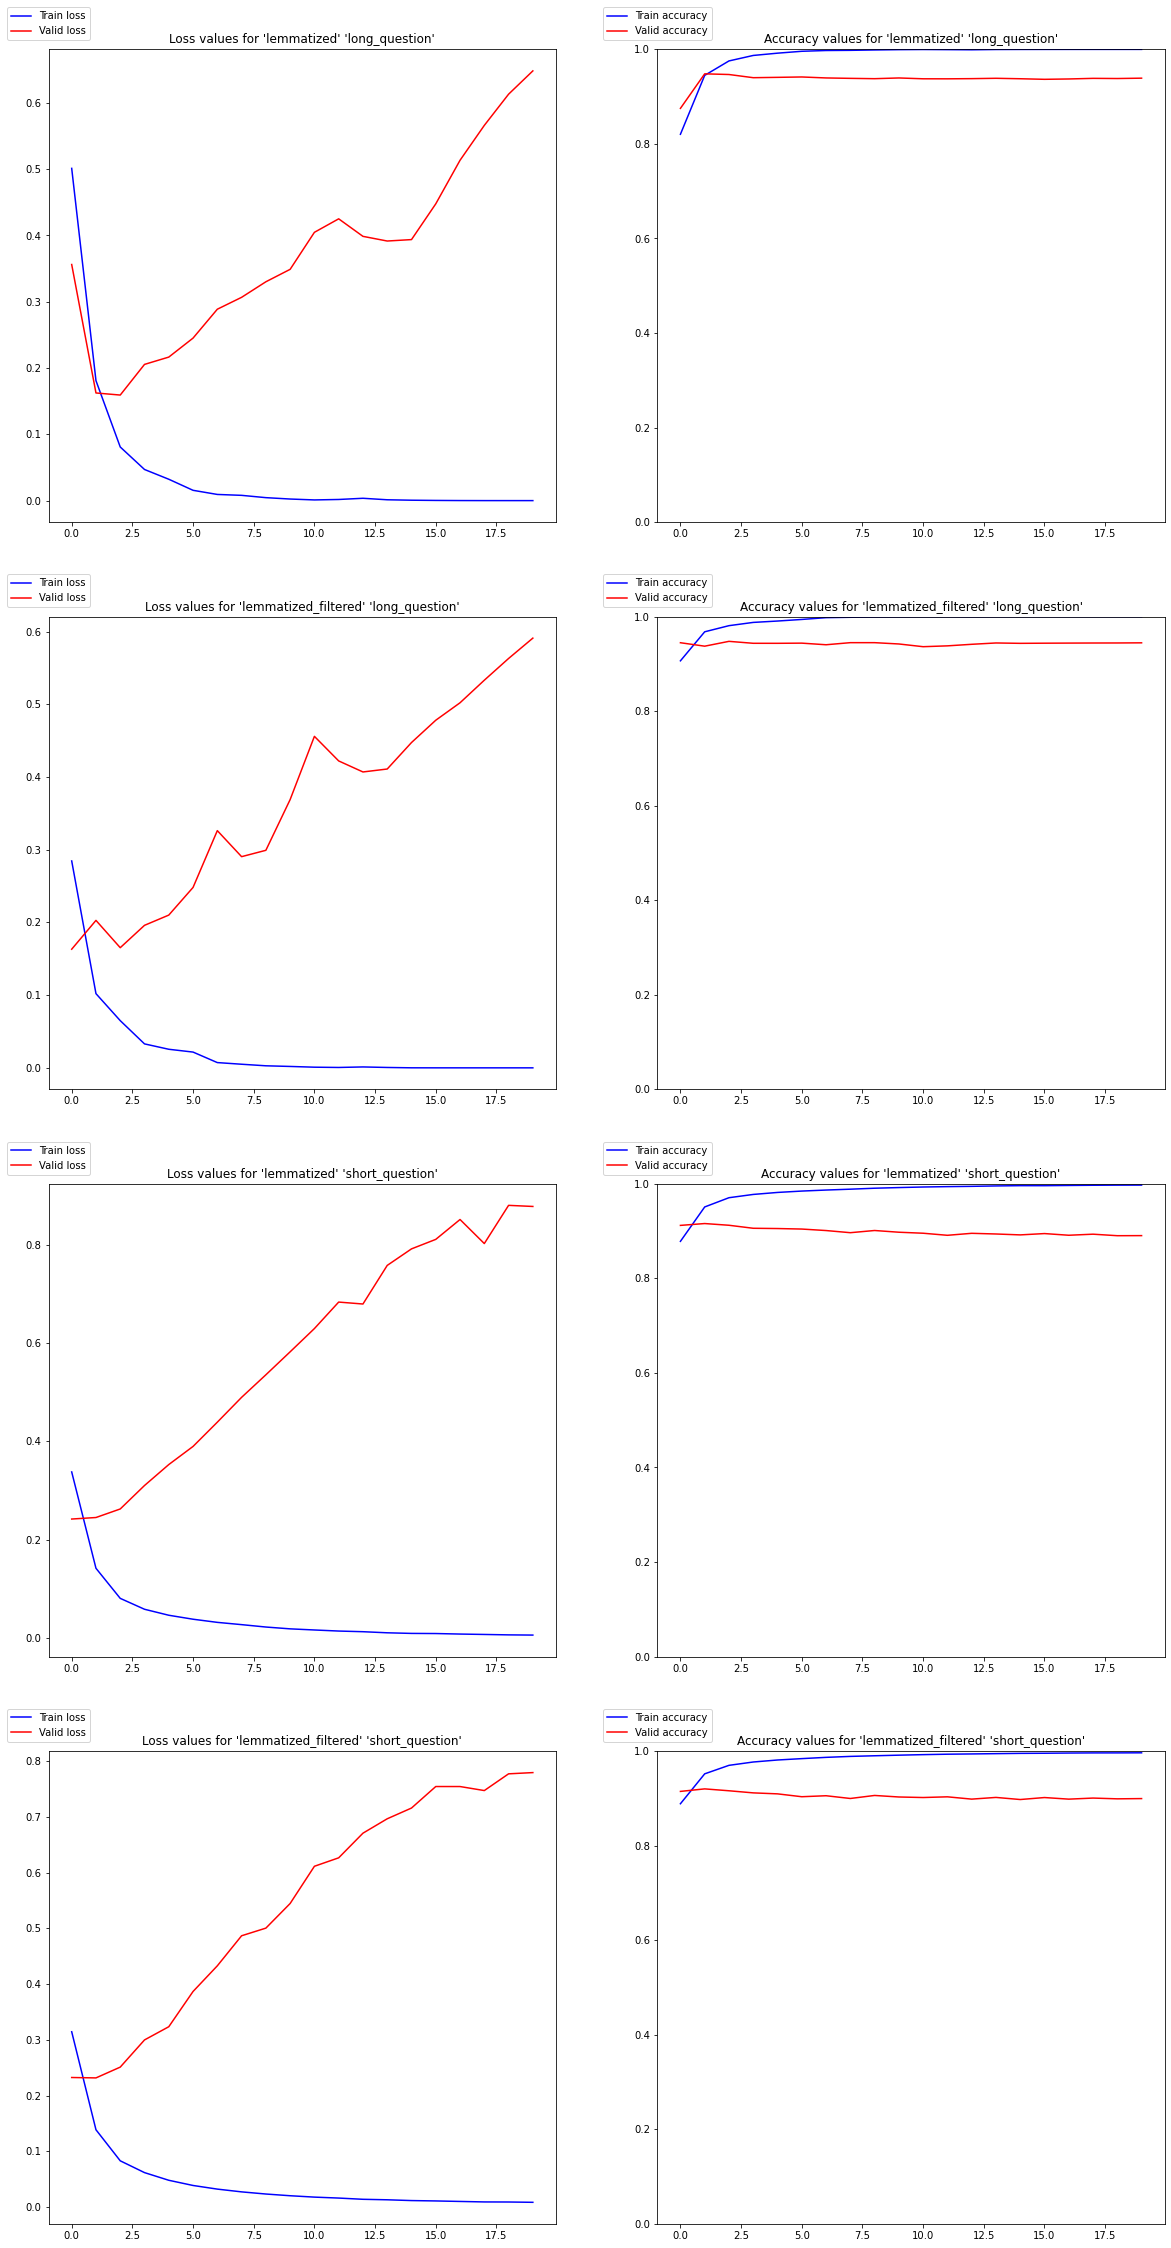

In [44]:
rows = len(args.datasets) * len(args.train_column)

fig, axs = plt.subplots(rows, 2, figsize=(10 * 2, 10 * rows))

for i, col in enumerate(args.train_column):
    for j, ds in enumerate(args.datasets):
        idx = i * len(args.datasets) + j

        axs[idx, 0].set_title(f"Loss values for '{ds}' '{col}'")
        axs[idx, 0].plot([*range(args.num_epochs)], train_losses[col][ds], color = 'b', label='Train loss')
        axs[idx, 0].plot([*range(args.num_epochs)], valid_losses[col][ds], color = 'r', label='Valid loss')
        axs[idx, 0].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)

        axs[idx, 1].set_title(f"Accuracy values for '{ds}' '{col}'")
        axs[idx, 1].axis(ymin = 0, ymax = 1)
        axs[idx, 1].plot([*range(args.num_epochs)], train_accuracies[col][ds], color = 'b', label='Train accuracy')
        axs[idx, 1].plot([*range(args.num_epochs)], valid_accuracies[col][ds], color = 'r', label='Valid accuracy')
        axs[idx, 1].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)
    
plt.show()

In [45]:
predictions = {}
test_target = {}

for ds in args.datasets:
    predictions[ds] = {}
    test_target[ds] = {}
    
    for tc in args.train_column:
        _, _, test_iterator = iterators[tc][ds]
    
        question_field = fields[tc][ds][0][1]
        input_dim = len(question_field.vocab)
        output_dim = len(target_names)
    
        model = LSTMClassifier(input_dim, args.embedding_dim, args.hidden_dim, output_dim, question_field)
    
        test_bar = notebook.tqdm(desc=f"'{ds} {tc}' test", total=len(test_iterator), position=0, leave=True)

        model.load_state_dict(torch.load(args.model_state_file + "_" + \
                                                            ds + "_" + \
                                                            tc + ".pth"))
        model = model.to(device)

        _, _, predictions[ds][tc] = evaluate_model(model, test_iterator, optimizer, criterion, test_bar)
    
        temp = []
        for batch in test_iterator:
            temp += batch.main_category.tolist()
        
        test_target[ds][tc] = [fields[tc][ds][1][1].vocab[val] for val in temp]    
        predictions[ds][tc] = [fields[tc][ds][1][1].vocab[val] for val in predictions[ds][tc]]

'lemmatized long_question' test:   0%|          | 0/330 [00:00<?, ?it/s]

'lemmatized short_question' test:   0%|          | 0/330 [00:00<?, ?it/s]

'lemmatized_filtered long_question' test:   0%|          | 0/330 [00:00<?, ?it/s]

'lemmatized_filtered short_question' test:   0%|          | 0/330 [00:00<?, ?it/s]

In [46]:
accuracy = {}

for tc in args.train_column:

    accuracy[tc] = {}

    for ds in args.datasets:
        pred = predictions[ds][tc]
        accuracy[tc][ds] = round(accuracy_score(test_target[ds][tc], pred), 3)

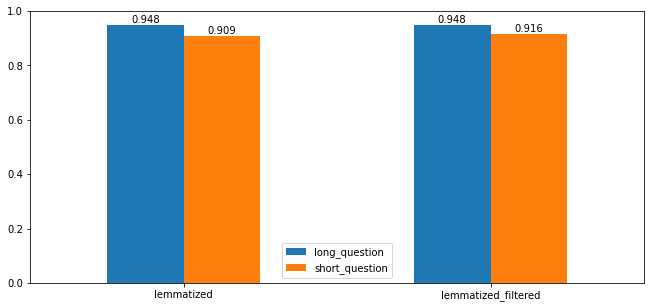

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))

acc_df = pd.DataFrame({f"{tc}": accuracy[tc].values() for tc in args.train_column}, index=args.datasets)        
acc_df.plot(kind='bar', ax=ax)

ax.axis(ymax = 1)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

for label in ax.containers:
    ax.bar_label(label)
    
plt.show()

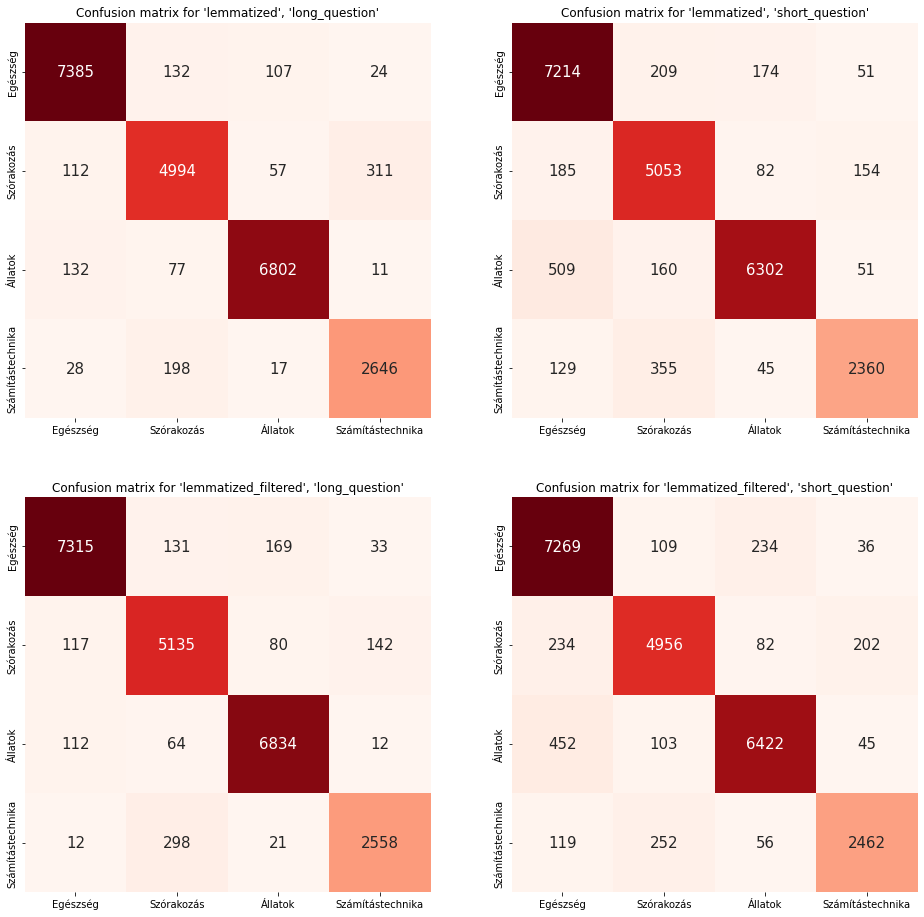

In [39]:
fig, axs = plt.subplots(len(args.datasets), len(args.train_column), figsize=(8 * len(args.train_column), 8 * len(args.datasets)))

for i, dataset in enumerate(args.datasets):
    for j, train_column in enumerate(args.train_column):
        axs[i, j].set_title(f"Confusion matrix for '{dataset}', '{train_column}'")
    
        pred = predictions[dataset][train_column]
    
        cm = confusion_matrix(test_target[dataset][train_column], pred)
        cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    
        heatmap = sn.heatmap(cm_df, annot=True, ax=axs[i, j], cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)

plt.show()

In [40]:
for ds in args.datasets:
    for tc in args.train_column:
        pred = predictions[ds][tc]
        report = classification_report(test_target[ds][tc], pred, target_names=target_names)
        print(f"Classification report for '{ds}' '{tc}':\n{report}\n{'=' * 60}")

Classification report for 'lemmatized' 'long_question':
                  precision    recall  f1-score   support

        Egészség       0.96      0.97      0.97      7648
      Szórakozás       0.92      0.91      0.92      5474
         Állatok       0.97      0.97      0.97      7022
Számítástechnika       0.88      0.92      0.90      2889

        accuracy                           0.95     23033
       macro avg       0.94      0.94      0.94     23033
    weighted avg       0.95      0.95      0.95     23033

Classification report for 'lemmatized' 'short_question':
                  precision    recall  f1-score   support

        Egészség       0.90      0.94      0.92      7648
      Szórakozás       0.87      0.92      0.90      5474
         Állatok       0.95      0.90      0.93      7022
Számítástechnika       0.90      0.82      0.86      2889

        accuracy                           0.91     23033
       macro avg       0.91      0.90      0.90     23033
    weighted